In [3]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision import transforms
import os
import torch.nn.functional as F

from config import train_config, input_config
from model import SRGAN_GEN, SRGAN_DISC
from loss import PerceptualLoss, DiscriminatorLoss
from utils import psnr_srgan, ssim_srgan
from data import UcsrTrainValidDataset
import matplotlib.pyplot as plt

In [2]:
train_valid = UcsrTrainValidDataset(train_config['train_lr_path'], train_config['train_hr_path'])
train_data = train_valid.get_train()
valid_data = train_valid.get_valid()

train_loader = DataLoader(train_data, batch_size=train_config['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=train_config['batch_size'],  shuffle=False)

*****train len: 80
80
*****valid len: 20
20


In [3]:
train_data.__len__()

19

In [3]:
train_data[0][0].shape

torch.Size([3, 24, 24])

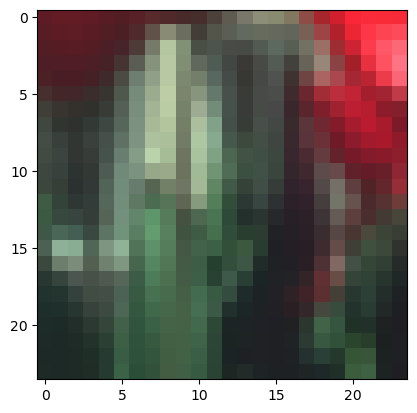

In [4]:
plt.imshow(train_data[0][0].permute(1, 2, 0).cpu().numpy())

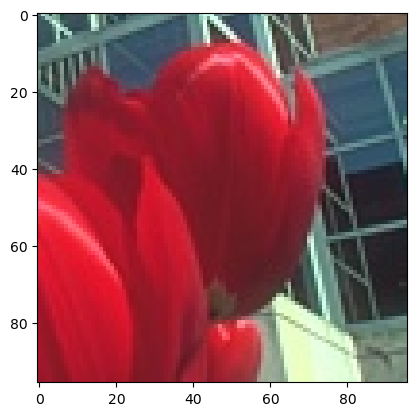

In [5]:
plt.imshow(train_data[0][1].permute(1, 2, 0).cpu().numpy())

In [6]:
input, target = train_data[0]


psnr_srgan( F.interpolate(input.unsqueeze(0), scale_factor=4, mode='bilinear', align_corners=False).squeeze(0), target)

Max value in input: tensor(0.8393)
Max value in target: tensor(1.)
shape: torch.Size([3, 96, 96]), torch.Size([3, 96, 96])


np.float64(24.106515065430315)

In [33]:
input.shape

torch.Size([3, 24, 24])

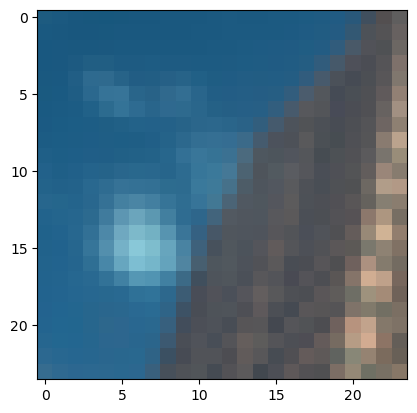

In [7]:
plt.imshow(input.permute(1, 2, 0).numpy())

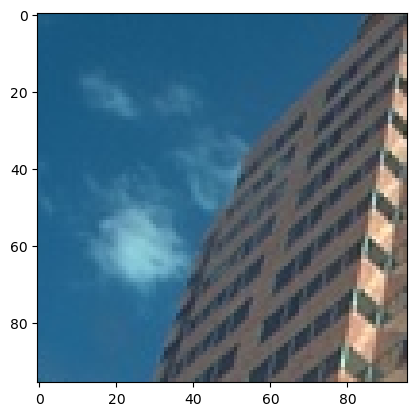

In [8]:
plt.imshow(target.permute(1, 2, 0).numpy())

In [9]:
input, target = valid_data[0]

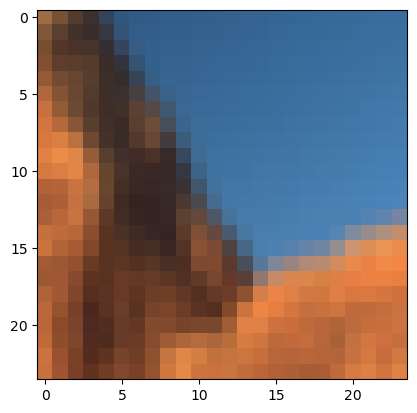

In [10]:
plt.imshow(input.permute(1, 2, 0).numpy())

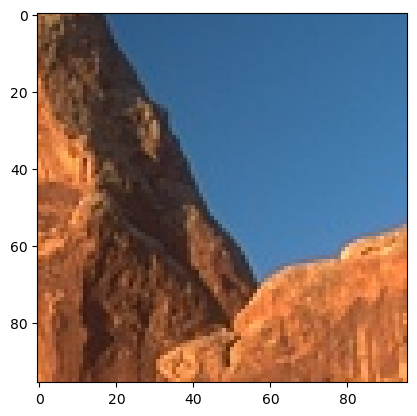

In [11]:
plt.imshow(target.permute(1, 2, 0).numpy())

In [12]:
a = train_data[0][1]
psnr_srgan(a, a)

Max value in input: tensor(1.)
Max value in target: tensor(1.)
shape: torch.Size([3, 96, 96]), torch.Size([3, 96, 96])


100

In [48]:
print(len(input))

3


 50%|█████     | 1/2 [00:08<00:08,  8.89s/it]

input_train shape: torch.Size([16, 3, 24, 24]), target_train type: torch.Size([16, 3, 96, 96])
Max value in input: tensor(0.6198)
Max value in target: tensor(1.)


100%|██████████| 2/2 [00:10<00:00,  5.31s/it]


input_train shape: torch.Size([3, 3, 24, 24]), target_train type: torch.Size([3, 3, 96, 96])
Max value in input: tensor(0.4362)
Max value in target: tensor(1.)
Epoch 1 / Generator Loss: 0.0878223368996068, Discriminator Loss: 0.5760598629467973,        PSNR: 0.9148842692375183, SSIM: 0.006177215371280909


 17%|█▋        | 1/6 [00:01<00:05,  1.17s/it]

Max value in input: tensor(0.9961)
Max value in target: tensor(0.9961)


 33%|███▎      | 2/6 [00:02<00:04,  1.17s/it]

Max value in input: tensor(1.)
Max value in target: tensor(1.)


 50%|█████     | 3/6 [00:03<00:03,  1.17s/it]

Max value in input: tensor(1.)
Max value in target: tensor(1.)


 67%|██████▋   | 4/6 [00:04<00:02,  1.17s/it]

Max value in input: tensor(1.)
Max value in target: tensor(1.)


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

Max value in input: tensor(0.)
Max value in target: tensor(0.)
Max value in input: tensor(0.)
Max value in target: tensor(0.)
Validation PSNR: 7.407407407407407, SSIM: nan


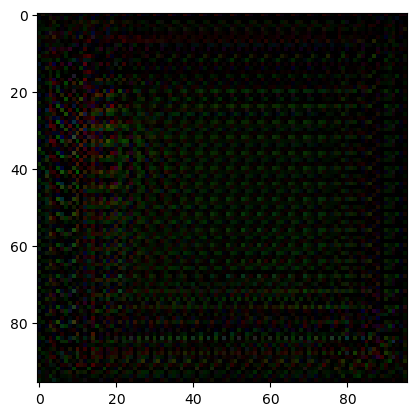

In [ ]:
train_test = UcsrTrainValidDataset(train_config['train_lr_path'], train_config['train_hr_path'])
train_data = train_test.get_train()
valid_data = train_test.get_valid()

train_loader = DataLoader(train_data, batch_size=train_config['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=train_config['batch_size'],  shuffle=False)

# 모델 및 옵티마이저, 손실함수
generator = SRGAN_GEN().to(train_config['device'])
discriminator = SRGAN_DISC().to(train_config['device'])
optimizer_gen = optim.Adam(generator.parameters(), lr=train_config['learning_rate'])
optimizer_disc = optim.Adam(discriminator.parameters(), lr=train_config['learning_rate'])
criterion_gen = PerceptualLoss().to(train_config['device'])
criterion_disc = DiscriminatorLoss().to(train_config['device'])

for epoch in range(1, train_config['num_epochs']):
    #### train ####
    avg_train_loss_gen = 0
    avg_train_loss_disc = 0
    avg_train_psnr = 0
    avg_train_ssim = 0
    epoch_train_loss_gen = 0
    epoch_train_loss_disc = 0
    epoch_train_psnr = 0
    epoch_train_ssim = 0
    num_of_images = 0
    
    for input_train, target_train in tqdm(train_loader):
        print(f'input_train shape: {input_train.shape}, target_train type: {target_train.shape}')
        generator.train()
        discriminator.train()
        input_train = input_train.to(train_config['device'])
        target_train = target_train.to(train_config['device'])
        num_of_images += input_train.shape[0]
        
        # generator 업데이트    
        generated_image = generator(input_train).to(train_config['device'])
        discriminated_output = discriminator(generated_image)
    
        optimizer_gen.zero_grad()
        loss_gen = criterion_gen(generated_image, discriminated_output, target_train)
        loss_gen.backward()
        optimizer_gen.step()
        
        # generator loss, psnr, ssim 축적
        epoch_train_loss_gen += loss_gen.item()
        temp_psnr = psnr_srgan(generated_image, target_train)
        print(f'batch PSNR: {temp_psnr}')
        epoch_train_psnr += temp_psnr
        epoch_train_ssim += ssim_srgan(generated_image, target_train)
        
        # discriminator 업데이트
        generated_image = generator(input_train)
        discriminated_fake = discriminator(generated_image.detach())
        discriminated_real = discriminator(target_train)
        
        optimizer_disc.zero_grad()
        loss_disc = criterion_disc(discriminated_fake, discriminated_real)
        loss_disc.backward()
        optimizer_disc.step()
        
        # discriminator loss 축적
        epoch_train_loss_disc += loss_disc.item()

    print(f'Total PSNR per batch: {epoch_train_psnr}')
    avg_train_loss_gen = epoch_train_loss_gen / len(train_loader.dataset)
    avg_train_loss_disc = epoch_train_loss_disc / len(train_loader.dataset)
    avg_train_psnr = epoch_train_psnr / num_of_images
    avg_train_ssim = epoch_train_ssim / num_of_images
    print(f'Epoch {epoch} / Generator Loss: {avg_train_loss_gen}, Discriminator Loss: {avg_train_loss_disc},\
        PSNR: {avg_train_psnr}, SSIM: {avg_train_ssim}')
        
    #### eval ####
    avg_val_psnr_gen = 0
    avg_val_ssim_gen = 0
    epoch_val_psnr_gen = 0
    epoch_val_ssim_gen = 0
    generator.eval()
    for input_val, target_val in tqdm(valid_loader):
        print(f'input_valid shape: {input_val.shape}, target_valid type: {target_val.shape}')
        input_val = input_val.to(train_config['device'])
        target_val = target_val.to(train_config['device'])
        
        generated_image = generator(input_val).to(train_config['device'])
        epoch_val_psnr_gen += psnr_srgan(generated_image, target_val)
        epoch_val_ssim_gen += ssim_srgan(generated_image, target_val)
    
    avg_val_psnr_gen = epoch_val_psnr_gen / len(valid_loader.dataset)
    avg_val_ssim_gen = epoch_val_ssim_gen / len(valid_loader.dataset)
    print(f'Validation PSNR: {avg_val_psnr_gen}, SSIM: {avg_val_ssim_gen}')
    
    if (epoch % train_config['saving_epoch_period'] == 0):
        torch.save(generator.state_dict(), os.path.join(train_config['model_save_path'], f'gen_epoch{epoch}'))
        torch.save(discriminator.state_dict(), os.path.join(train_config['model_save_path'], f'disc_epoch{epoch}'))